In [38]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from ucimlrepo import fetch_ucirepo

%matplotlib inline

In [55]:
train_df = pd.read_csv('data/train.csv', index_col = 'id')
test_df = pd.read_csv('data/test.csv', index_col = 'id')
original_df = fetch_ucirepo(id = 848)['data']['original']

In [56]:
labels = train_df.pop('class')
labels_bool = labels == 'p'
initial_features = list(train_df.columns)

print(f'Train shape: {train_df.shape}')
print(f'Original data shape: {original_df.shape}')
print(f'Test shape: {test_df.shape}')
train_df.head()

Train shape: (3116945, 20)
Original data shape: (61069, 21)
Test shape: (2077964, 20)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [49]:
train_df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   cap-diameter          3116941 non-null  float64
 1   cap-shape             3116905 non-null  object 
 2   cap-surface           2445922 non-null  object 
 3   cap-color             3116933 non-null  object 
 4   does-bruise-or-bleed  3116937 non-null  object 
 5   gill-attachment       2593009 non-null  object 
 6   gill-spacing          1858510 non-null  object 
 7   gill-color            3116888 non-null  object 
 8   stem-height           3116945 non-null  float64
 9   stem-width            3116945 non-null  float64
 10  stem-root             359922 non-null   object 
 11  stem-surface          1136084 non-null  object 
 12  stem-color            3116907 non-null  object 
 13  veil-type             159452 non-null   object 
 14  veil-color            375998 non-null  

In [50]:
# Examining percentage of missing data for each feature
percent_missing = (train_df.isna().sum() / train_df.shape[0]) * 100
print(percent_missing)

cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64


In [57]:
float_features = ['cap-diameter', 'stem-height', 'stem-width']
categorical_features = [feature for feature in initial_features if feature not in float_features]

# Making features consistent with those found in original dataset - synthetic data has created lot of artifact categories

print('Before processing:')
for feature in categorical_features: 
    print(f'{feature:30} {train_df[feature].nunique()}')

Before processing
cap-shape                      74
cap-surface                    83
cap-color                      78
does-bruise-or-bleed           26
gill-attachment                78
gill-spacing                   48
gill-color                     63
stem-root                      38
stem-surface                   60
stem-color                     59
veil-type                      22
veil-color                     24
has-ring                       23
ring-type                      40
spore-print-color              32
habitat                        52
season                         4
cap-shape                      7
cap-surface                    11
cap-color                      12
does-bruise-or-bleed           2
gill-attachment                7
gill-spacing                   3
gill-color                     12
stem-root                      5
stem-surface                   8
stem-color                     13
veil-type                      1
veil-color                     6
has-r

In [ ]:
print('\n After processing:')
for feature in initial_features:
    if feature in categorical_features:
        # Extracting true categories from original dataset
        categories = sorted(list(set(original_df[feature].dropna())))
        dtype = pd.CategoricalDtype(categories = categories, ordered = False)
        print(f'{feature:30} {len(dtype.categories)}')
        # Replacing categories that don't exist in original dataset with nan
        train_df.loc[~train_df[feature].isin(categories), feature] = np.nan
        test_df.loc[~test_df[feature].isin(categories), feature] = np.nan

        train_df[feature] = train_df[feature].astype(dtype)
        original_df[feature] = original_df[feature].astype(dtype)
        test_df[feature] = test_df[feature].astype(dtype)



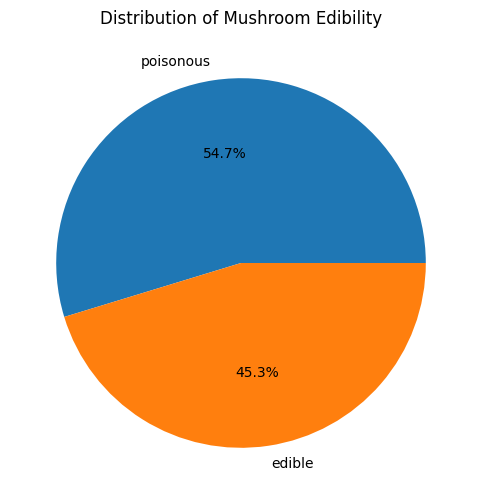

In [62]:
# Exploring balance of classes for target variable
plt.figure(figsize = (10, 6))
plt.pie(labels.value_counts(), labels = ['poisonous', 'edible'], autopct = '%.1f%%')
plt.title('Distribution of Mushroom Edibility')
plt.show()

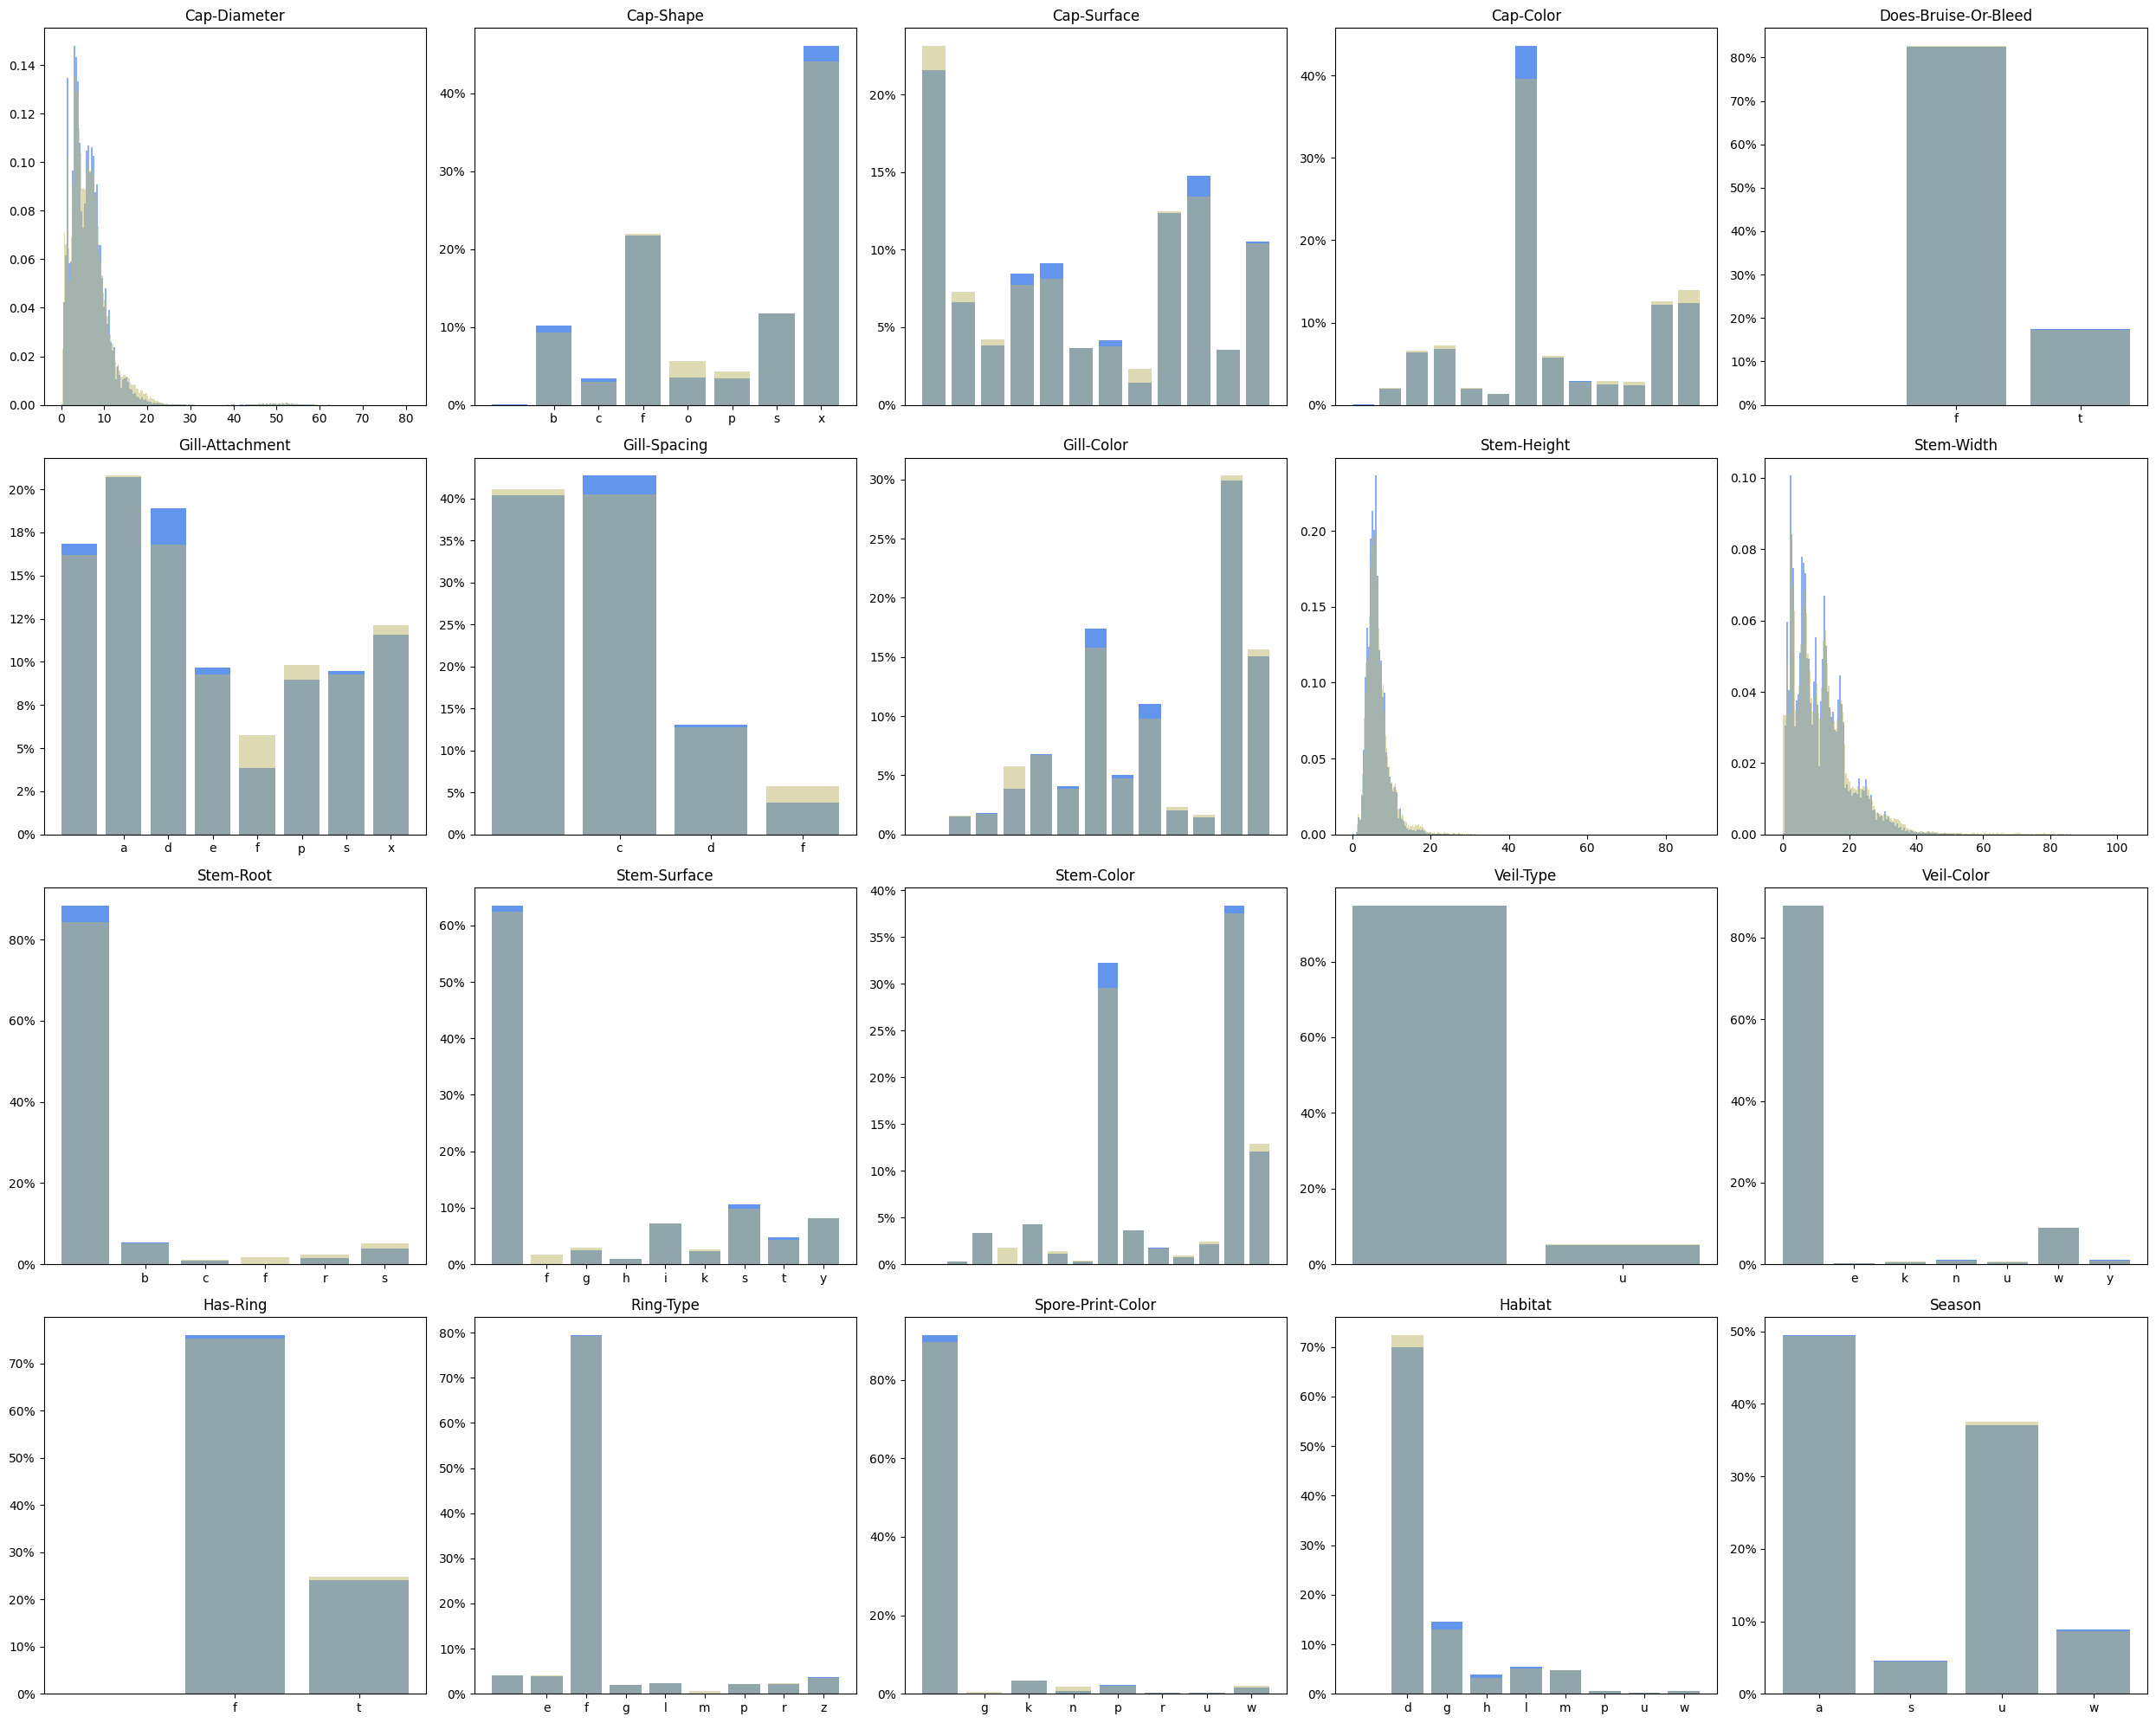

In [94]:
# Comparing variable distributions between synthetic/train and original data
fig, axs = plt.subplots(4, 5, figsize = (25, 20))

for feature, ax in zip(initial_features, axs.ravel()):
    if feature in float_features:
        ax.hist(train_df[feature], bins = 200, density = True, color = 'cornflowerblue', alpha = 0.75)
        ax.hist(original_df[feature], bins = 200, density = True, color = 'darkkhaki', alpha = 0.5)

    elif feature in categorical_features: 
        counts_train = train_df[feature].cat.codes.value_counts() / len(train_df)
        ax.bar(counts_train.index, counts_train, color = 'cornflowerblue')
        counts_original = original_df[feature].cat.codes.value_counts() / len(original_df)
        ax.bar(counts_original.index, counts_original, color = 'darkkhaki', alpha = 0.5)
        ax.yaxis.set_major_formatter('{x:.0%}')

        if len(counts_train) <= 10: 
            ax.set_xticks(np.arange(len(train_df[feature].dtype.categories)), train_df[feature].dtype.categories)
        else: 
            ax.set_xticks([])
    
    ax.set_title(f'{feature.title()}', fontsize = 12)

plt.tight_layout()
plt.show()


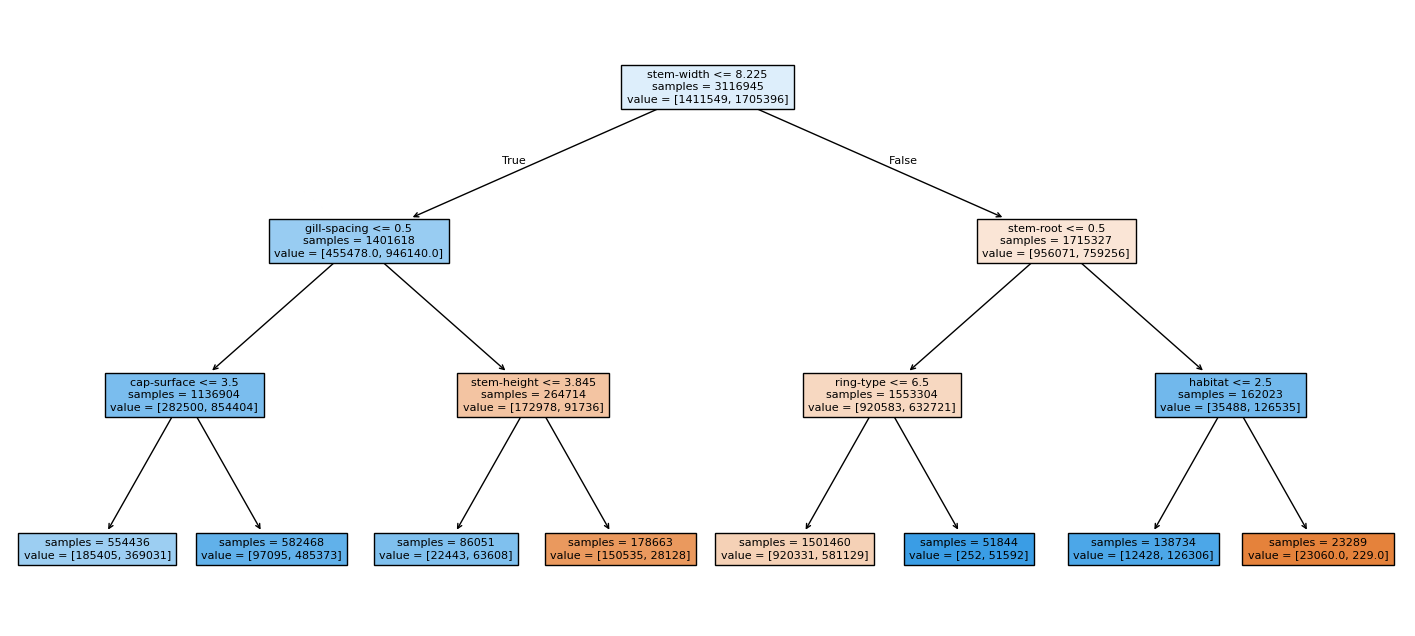

In [104]:
# Plotting some decision trees to look at feature importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import FunctionTransformer, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

def to_codes(df):
    return pd.DataFrame({col: df[col].cat.codes for col in df.columns})

model = make_pipeline(ColumnTransformer([('cat',
                                          FunctionTransformer(to_codes),
                                          train_df.select_dtypes('category').columns)], 
                                          remainder = SimpleImputer().set_output(transform = 'pandas'), 
                                          verbose_feature_names_out = False).set_output(transform = 'pandas'), 
                    DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 100))

model.fit(train_df[initial_features], labels)

plt.figure(figsize = (18, 8))
plot_tree(model[-1], feature_names = model[-1].feature_names_in_, fontsize = 8, impurity = False, filled = True, ax = plt.gca())
plt.show()

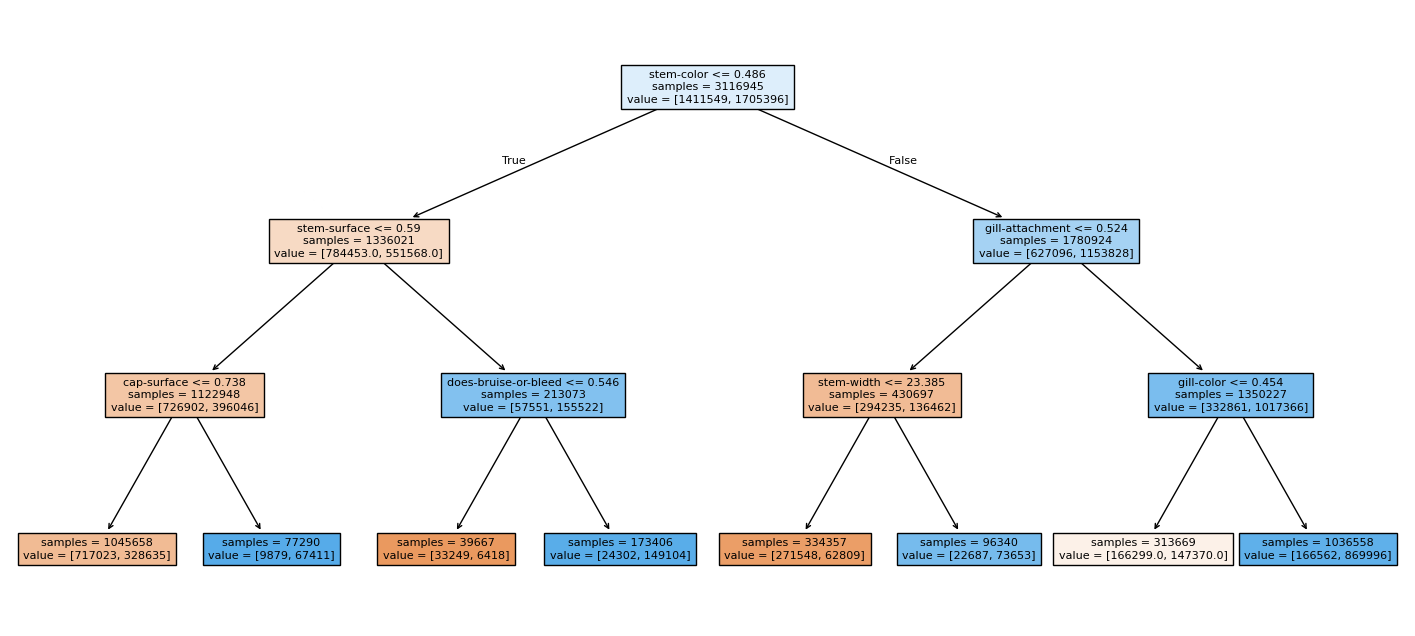

In [105]:
from matplotlib.pyplot import plot
from sklearn.preprocessing import TargetEncoder

model = make_pipeline(ColumnTransformer([('cat', TargetEncoder(), train_df.select_dtypes('category').columns)], 
                                         remainder = SimpleImputer().set_output(transform = 'pandas'),
                                         verbose_feature_names_out = False).set_output(transform = 'pandas'), 
                    DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 100))

model.fit(train_df[initial_features], labels)

plt.figure(figsize = (18, 8))
plot_tree(model[-1], feature_names = model[-1].feature_names_in_, fontsize = 8, impurity = False, filled = True, ax = plt.gca())
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold


crossval = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4423)

def cross_validate(model, name, 
                   features = initial_features, 
                   fit_params = {}
                   plot_histogram = False,
                   use_eval_set = False, 
                   use_original = False):
    pass


# make logistic model and neural network using pytorch/keras - compare their results 